In [196]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('seaborn')


def first_interaction_pdf(x, XS):
    """
    Probability Density Function for the first interaction of a neutron inside
    a medium of macroscopic cross section XS at distance x and x + dx

    :param x: distance travelled by neutron inside the material
    :param XS: macroscopic cross section of the material
    :return: probability of interaction
    """
    return XS*np.exp(-XS*x)


def first_interaction_cdf(x, XS):
    """
    Cumulative Distribution Function for the first interaction of a neutron inside
    a medium of macroscopic cross section XS at distance x

    :param x: distance travelled by neutron inside the material
    :param XS: macroscopic cross section of the material
    :return: cumulative probability of interaction
    """
    return 1 - np.exp(-XS*x)


def first_interaction_inv_cdf(probability, XS):
    """
    inverse CDF for first interaction

    probability: a number between 0 and 1
    """
    return -np.log(1 - probability)/XS


def first_interaction_inv_cdf_alt(prob, XS):
    """
    Not the inverse CDF, but since the probabilities are sampled uniformly
    distributed, it doesn't make a difference and abstracts one operation,
    so it's faster.
    Doesn't make a difference here. Only relevant in real Monte Carlo codes
    with millions or billions of neutrons per generation.

    There is a negligible but funny side effect that as written, probabilities
    are sampled in the interval [0, 1). The compliment of this as in the
    original inverse CDF (i.e., 1 - probability) results in a sample in
    the interval of (0, 1]. It means that the original function can't have a
    neutron that doesn't move at all, which makes sense, and includes a neutron
    that moves the whole length, whereas this modified version can have a
    neutron that interacts in the same place it's born and can't move the whole
    length. In practice this should make no difference though ¯\_(ツ)_/¯
    """
    return -np.log(prob)/XS


def sample_first_interaction(sample_size, XS, F=first_interaction_inv_cdf, rng=np.random):
    """
    To have a reproducible sequence, only need to pre-generate the RNG with seed
    and pass to the function
    rng = np.random.default_rng(42)

    :param sample_size: number of neutrons to generate probabilities of first interaction
    :param XS: macroscopic cross section of the material
    :param F: the inverse CDF function that receives a probability and returns the
        probable length of first interaction
    :param rng: the random number generator function
    :return: probable distances to first interaction
    """
    probabilities = rng.random(sample_size)

    return F(probabilities, XS)


Probability Density Function of first interaction

We know experimentally that in a transmission/attenuation experiment, the
incident particle intensity reduces exponentially as:
$I(x) = I_0 \mathrm{e}^{-\Sigma_{\mathrm{t}} x}$

Rearranging this, we can get a fraction of transmitted neutrons, which is a
quantity in the range [0,1] that can be said to represent the probability
$P_0(x)$ that an incident neutron will be transmitted until distance x through
the material without any interaction.

$I(x) = I_0 \mathrm{e}^{-\Sigma_{\mathrm{t}} x} \rightarrow \frac{I(x)}{I_0} = \mathrm{e}^{-\Sigma_{\mathrm{t}} x} = P_0(x)$

If we define the probability of interaction per unit length as the macroscopic
cross section:

$\frac{\mathrm{d}P}{\mathrm{d}x} = \Sigma_{\mathrm{t}}$

Then the probability $\mathrm{d}P_1$ of having a first interaction after
distance x between x and dx is the probability of not interacting until x,
given by $P_0(x)$ multiplied by the probability of having an interaction in
the next length dx:

$\mathrm{d}P_1 = P_0 \mathrm{d}P = \mathrm{e}^{-\Sigma_{\mathrm{t}} x} \ \Sigma_{\mathrm{t}} \ \mathrm{d}x$

This is the PDF for the first interaction of a neutron moving through a domain.
For a 1D domain the probability of interaction in any infinitesimal interval is
plotted below.

Notice that this gives the probability of any interaction.
To figure out exactly what reaction it is, we would have to sample the
possible interactions.

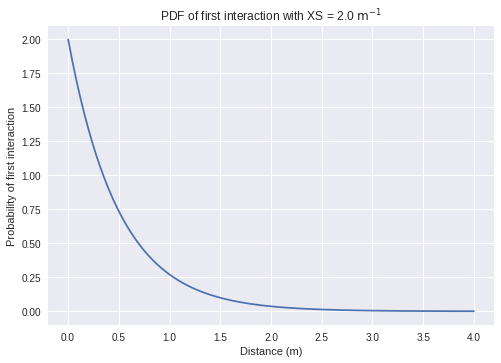

In [197]:
XS = 2.0

slab = np.linspace(0, 4, num=101)

fig, ax = plt.subplots()
ax.plot(slab, first_interaction_pdf(slab, XS))
ax.set(xlabel='Distance (m)', ylabel='Probability of first interaction',
       title='PDF of first interaction with XS = {} {}'.format(XS, '$\mathrm{m}^{-1}$'))
plt.savefig('First_collision_PDF.pdf')

Cumulative Distribution Function of first interaction

The first interaction CDF can be calculated by integrating the PDF over the domain

$F(x) = \int_{0}^{x} \Sigma_{\mathrm{t}} \ \mathrm{e}^{-\Sigma_{\mathrm{t}} x} \mathrm{d}x = \left. - \mathrm{e}^{-\Sigma_{\mathrm{t}} x} \right|_{0}^{x} = 1 - \mathrm{e}^{-\Sigma_{\mathrm{t}} x} = \xi$

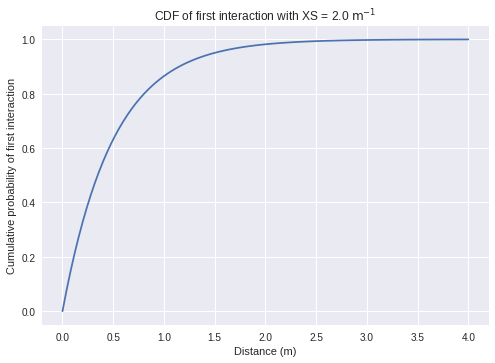

In [198]:
fig, ax = plt.subplots()
ax.plot(slab, first_interaction_cdf(slab, XS))
ax.set(xlabel='Distance (m)', ylabel='Cumulative probability of first interaction',
       title='CDF of first interaction with XS = {} {}'.format(XS, '$\mathrm{m}^{-1}$'))
plt.savefig('First_collision_CDF.pdf')

Inverse CDF

If the CDF is a function that shows property:
$F(x) = (\xi)$

The inverse function is a function that presents the property:
$F^{-1}(\xi) = x$

We can obtain it quite easily in this case by rearranging the terms of the CDF

$\xi = 1 - \mathrm{e}^{-\Sigma x} \rightarrow 1 - \xi = \mathrm{e}^{-\Sigma x} \rightarrow \ln(1 - \xi) = -\Sigma x$

Therefore, the inverse function is:

$x = \frac{-\ln(1 - \xi)}{\Sigma} = F^{-1}(\xi)$

/tmp/ipykernel_11023/1079496430.py:38: RuntimeWarning: divide by zero encountered in log
  return -np.log(1 - probability)/XS


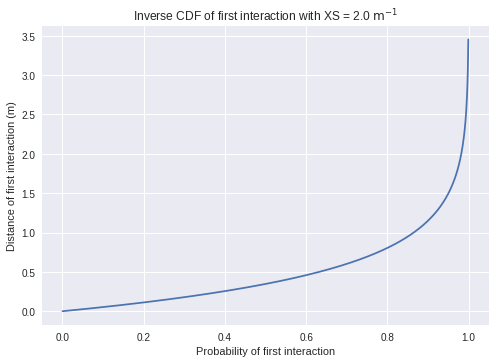

In [199]:
probability_range = np.linspace(0, 1, num=1001)

fig, ax = plt.subplots()
ax.plot(probability_range, first_interaction_inv_cdf(probability_range, XS))
ax.set(xlabel='Probability of first interaction', ylabel='Distance of first interaction (m)',
       title='Inverse CDF of first interaction with XS = {} {}'.format(XS, '$\mathrm{m}^{-1}$'))
plt.savefig('First_collision_inv_CDF.pdf')

3 / 1000 neutrons transmitted
Fraction of transmission: 0.003


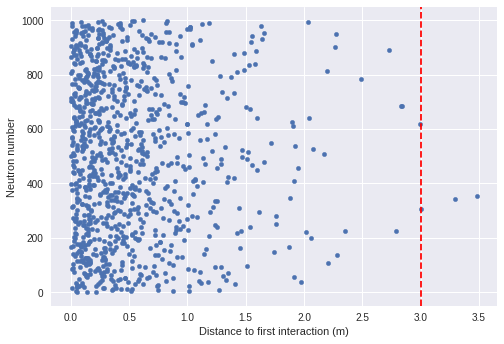

In [200]:
def filter_transmitted(distances, boundary):
    return np.sum(distances > boundary)


def plot_distances(distances, boundary=None, s=20):
    fig, ax = plt.subplots()
    ax.scatter(distances, np.arange(len(distances)), s=s)
    ax.set(xlabel='Distance to first interaction (m)', ylabel='Neutron number')
    if boundary:
        ax.axvline(boundary, color='red', linestyle='--')


def report(transmitted, sample_size):
    print(f'{transmitted} / {sample_size} neutrons transmitted')
    print(f'Fraction of transmission: {transmitted/sample_size}')


thickness = 3.0
neutrons = 1000

first_interactions = sample_first_interaction(neutrons, XS)

report(filter_transmitted(first_interactions, thickness), neutrons)
plot_distances(first_interactions, thickness)

7 / 2000 neutrons transmitted
Fraction of transmission: 0.0035
9 / 4000 neutrons transmitted
Fraction of transmission: 0.00225
24 / 8000 neutrons transmitted
Fraction of transmission: 0.003
34 / 16000 neutrons transmitted
Fraction of transmission: 0.002125
79 / 32000 neutrons transmitted
Fraction of transmission: 0.00246875
146 / 64000 neutrons transmitted
Fraction of transmission: 0.00228125
334 / 128000 neutrons transmitted
Fraction of transmission: 0.002609375


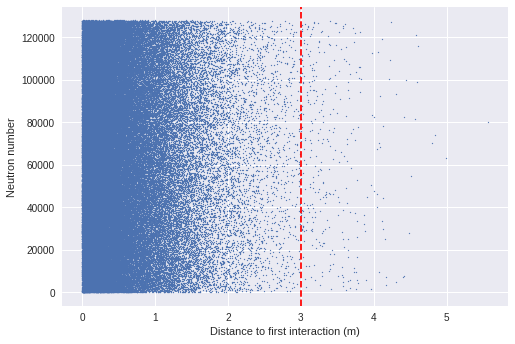

In [201]:
samples = neutrons*np.array([2, 4, 8, 16, 32, 64, 128])

for sample in samples:
    first_interactions = sample_first_interaction(sample, XS)
    report(filter_transmitted(first_interactions, thickness), sample)

plot_distances(first_interactions, thickness, s=1)
plt.savefig('Transmission_experiment.pdf')

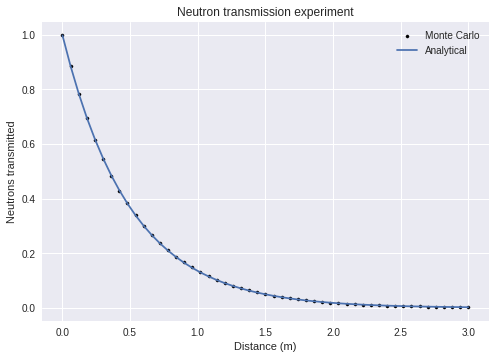

In [202]:
slab_p = np.linspace(0.001, thickness, num=51)
cells = np.zeros_like(slab_p)

with np.nditer(cells, op_flags=['readwrite']) as cl:
    for c, p in zip(cl, slab_p):
        c[...] = np.sum(first_interactions > p)/sample

I_by_I0 = np.exp(-XS * slab_p)

fig, ax = plt.subplots()
ax.scatter(slab_p, cells, s=10, c='k', label='Monte Carlo')
ax.plot(slab_p, I_by_I0, label='Analytical')
ax.legend()
ax.set(xlabel='Distance (m)', ylabel='Neutrons transmitted',
       title='Neutron transmission experiment')

plt.savefig('Transmission_verification.pdf')